<a href="https://colab.research.google.com/github/leonardofelix346/lia1_2025_2/blob/main/itools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importando o módulo files da biblioteca google.colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leonardo346","key":"abcc38000722b9f8f10f33d2b2c73aa8"}'}

In [2]:
#configurar o Kaggle no Colab
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle --quiet


In [3]:
#baixando e extraindo um dataset do Kaggle
!kaggle datasets download -d salmaneunus/mechanical-tools-dataset
!unzip -q mechanical-tools-dataset.zip -d /content/mechtools



Dataset URL: https://www.kaggle.com/datasets/salmaneunus/mechanical-tools-dataset
License(s): copyright-authors
 88% 571M/652M [00:03<00:01, 63.9MB/s]
100% 652M/652M [00:03<00:00, 195MB/s] 


In [4]:
#verificar se o dataset foi extraído corretamente e se as pastas das classes estão no lugar certo
import os

TRAIN_DIR = '/content/mechtools/train_data_V2'
VAL_DIR   = '/content/mechtools/validation_data_V2'

print("Conteúdo de TRAIN_DIR:", os.listdir(TRAIN_DIR))
print("Conteúdo de VAL_DIR:", os.listdir(VAL_DIR))

Conteúdo de TRAIN_DIR: ['train_data_V2']
Conteúdo de VAL_DIR: ['validation_data_V2']


Conteúdo de BASE_DIR:
['hammer.csv.csv', 'validation_data_V2', 'Mechanical Tools Image dataset', 'test_data', 'train_data', 'train_data_V2', 'Annotated.csv', 'Mechanical_Tools_labelled.csv']

Treino encontrado em: /content/mechtools/train_data_V2/train_data_V2
Validação encontrada em: /content/mechtools/validation_data_V2/validation_data_V2


Carregando screwdriver: 100%|██████████| 400/400 [00:00<00:00, 514.36it/s]


Classes detectadas: ['hammer', 'screwdriver', 'wrench']
Treino: (2400, 150, 150, 3) Validação: (1200, 150, 150, 3)


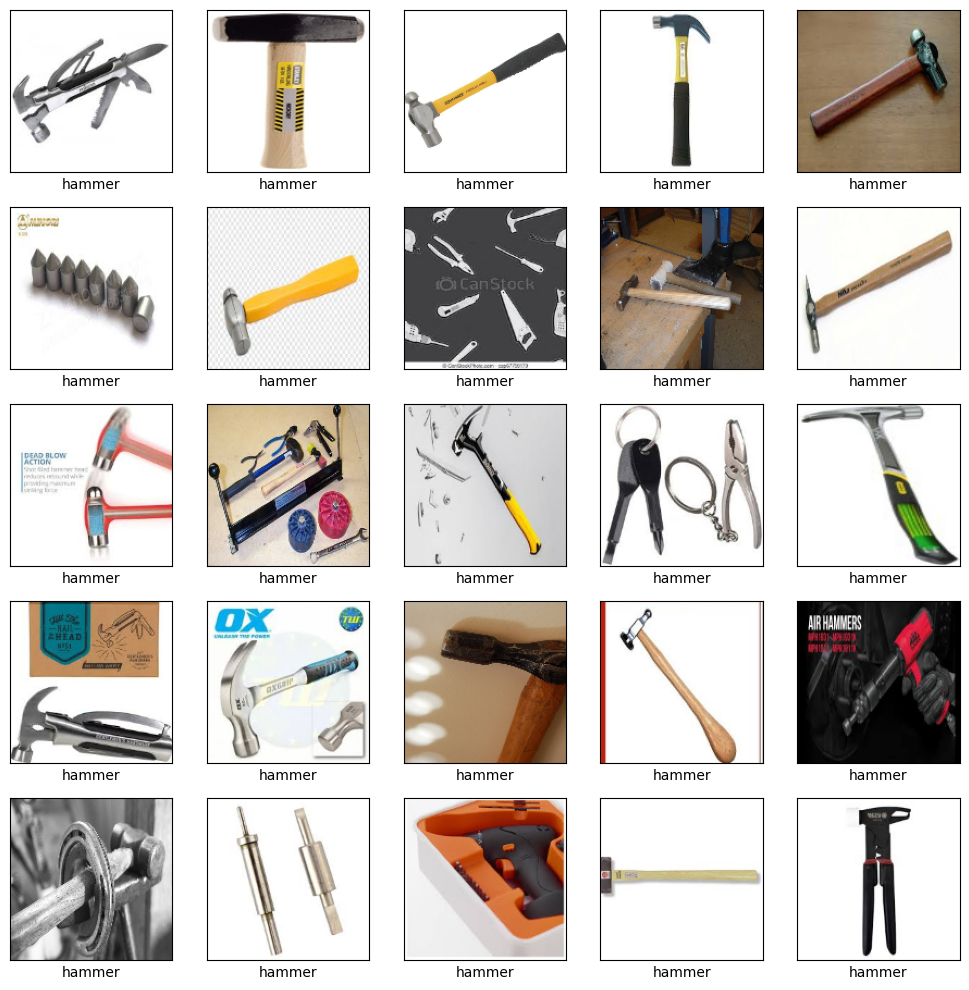

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.3509 - loss: 2.6099 - val_accuracy: 0.3350 - val_loss: 1.0974
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3446 - loss: 1.0945 - val_accuracy: 0.4025 - val_loss: 1.0832
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.4509 - loss: 1.0512 - val_accuracy: 0.4825 - val_loss: 1.0611
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5633 - loss: 0.9614 - val_accuracy: 0.5175 - val_loss: 1.0144
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6630 - loss: 0.8357 - val_accuracy: 0.5025 - val_loss: 1.0244
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6995 - loss: 0.7009 - val_accuracy: 0.5400 - val_loss: 1.0495
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7910 - loss: 0.5331 - val_accuracy: 0.5300 - val_loss: 1.2394
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.8551 - loss: 0.4015 - val_accuracy: 0.5467 -

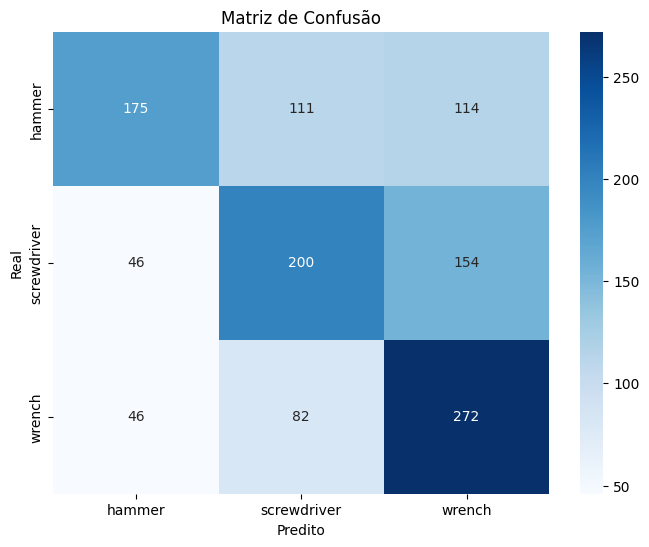

Relatório de Classificação:

              precision    recall  f1-score   support

      hammer       0.66      0.44      0.52       400
 screwdriver       0.51      0.50      0.50       400
      wrench       0.50      0.68      0.58       400

    accuracy                           0.54      1200
   macro avg       0.56      0.54      0.54      1200
weighted avg       0.56      0.54      0.54      1200



In [5]:

# Imports

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Localizar automaticamente pastas de treino e validação

BASE_DIR = "/content/mechtools"

# Listar tudo dentro da pasta base
print("Conteúdo de BASE_DIR:")
print(os.listdir(BASE_DIR))

# Procurar automaticamente as pastas corretas

def find_dataset_paths(base_dir):
    train_dir, val_dir = None, None
    for root, dirs, files in os.walk(base_dir):
        for d in dirs:
            lower = d.lower()
            if "train" in lower:
                train_dir = os.path.join(root, d)
            elif "val" in lower:
                val_dir = os.path.join(root, d)
    return train_dir, val_dir

TRAIN_DIR, VAL_DIR = find_dataset_paths(BASE_DIR)

print(f"\nTreino encontrado em: {TRAIN_DIR}")
print(f"Validação encontrada em: {VAL_DIR}")

if TRAIN_DIR is None or VAL_DIR is None:
    raise FileNotFoundError("Não foi possível localizar as pastas de treino e validação. Verifique a estrutura do dataset.")


# Função para carregar dataset

IMAGE_SIZE = (150, 150)

def load_data(base_path):
    images, labels = [], []
    class_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    for cls in class_folders:
        cls_path = os.path.join(base_path, cls)
        for fname in tqdm(os.listdir(cls_path), desc=f"Carregando {cls}"):
            img_path = os.path.join(cls_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)
            images.append(img)
            labels.append(cls)

    images = np.array(images, dtype="float32") / 255.0
    unique_classes = sorted(list(set(labels)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    labels_idx = np.array([class_to_idx[l] for l in labels], dtype="int32")

    return images, labels_idx, unique_classes


# Carregar treino e validação

train_images, train_labels, train_class_names = load_data(TRAIN_DIR)
val_images, val_labels, val_class_names = load_data(VAL_DIR)

# Garantir todas as classes
class_names = sorted(list(set(train_class_names + val_class_names)))
nb_classes = len(class_names)

print("Classes detectadas:", class_names)
print("Treino:", train_images.shape, "Validação:", val_images.shape)


# Função para visualizar imagens do dataset

def visualiza_imagens(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

# Visualizar imagens de treino
visualiza_imagens(train_images, train_labels, class_names)

# Criar modelo CNN

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(nb_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Treinar modelo

history = model.fit(
    train_images, train_labels,
    batch_size=128,
    epochs=20,
    validation_data=(val_images, val_labels)
)


# Avaliação do modelo

val_pred_probs = model.predict(val_images)
val_preds = np.argmax(val_pred_probs, axis=1)

# Matriz de confusão
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

# Relatório de classificação
report = classification_report(val_labels, val_preds, target_names=class_names)
print("Relatório de Classificação:\n")
print(report)


# Função para classificar imagens enviadas pelo usuário

def classify_uploaded_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = cv2.imread(filename)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
        img_array = np.expand_dims(img_resized, axis=0) / 255.0

        pred = model.predict(img_array)
        pred_class = class_names[np.argmax(pred)]
        print(f"Classe prevista: {pred_class}")

        plt.imshow(img_rgb)
        plt.title(f"Classe prevista: {pred_class}")
        plt.axis("off")
        plt.show()




Saving Screenshot 2025-09-07 172001.png to Screenshot 2025-09-07 172001 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Classe prevista: hammer


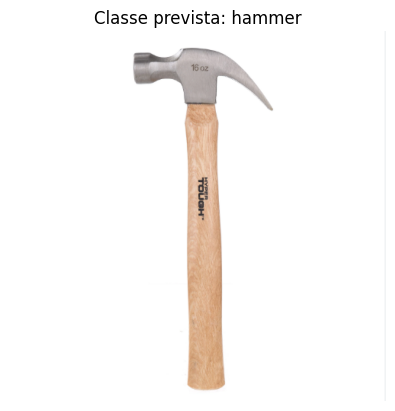

In [14]:
#Subir imagem para predição
classify_uploaded_image()